In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk

# Loading data

In [3]:
df=pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


> **We are performing this analysis on the Text column**

In [5]:
df.shape
#quite large dataset

(568454, 10)

In [6]:
df.info()
#no null values in the text

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


# EDA

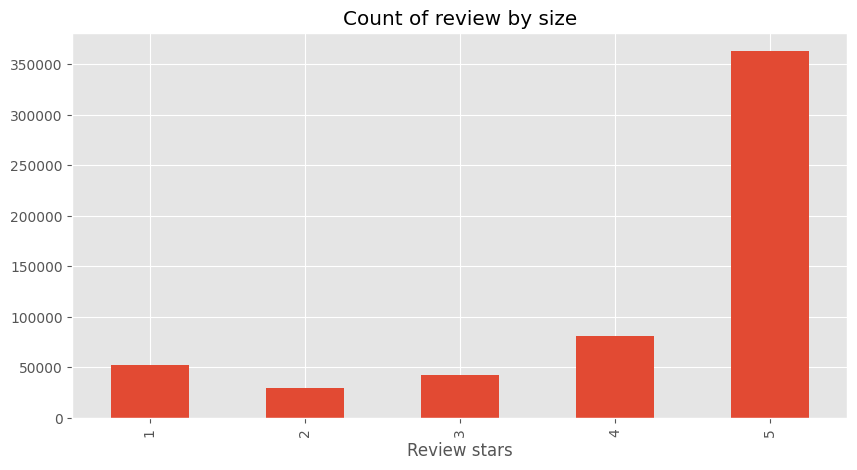

In [7]:
axis=df["Score"].value_counts().sort_index().plot(kind='bar',title="Count of review by size",figsize=(10,5))
axis.set_xlabel("Review stars")
plt.show()

> **There is a bias in positive review in this dataset.**

# VADER Sentiment Scoring

> **NLTK will get the neg/neu/pos scored of text**
> * This uses a "bag of words approach
>   * 1.Stop words removed (and, the,....etc)
>   * 2.each word is scored and combined to total score 

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia=SentimentIntensityAnalyzer()

**Run the polarity score on the whole dataset!**

In [9]:
results={}
for i ,row in tqdm(df.iterrows(),total=len(df)):
    text=row["Text"]
    myid=row["Id"]
    results[myid]=sia.polarity_scores(text)

    

  0%|          | 0/568454 [00:00<?, ?it/s]

In [10]:
vaders=pd.DataFrame(results).T
vaders=vaders.reset_index().rename(columns={'index':'Id'})
vaders=vaders.merge(df,how='left')

In [11]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**Visualize the positivity and negativity between 1 star and 5 stars review**

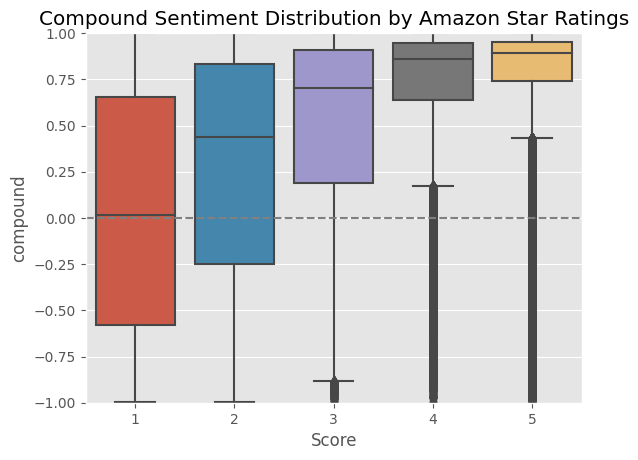

In [12]:
sns.boxplot(data=vaders, x="Score", y="compound")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Compound Sentiment Distribution by Amazon Star Ratings")
plt.ylim(-1, 1)
plt.show()

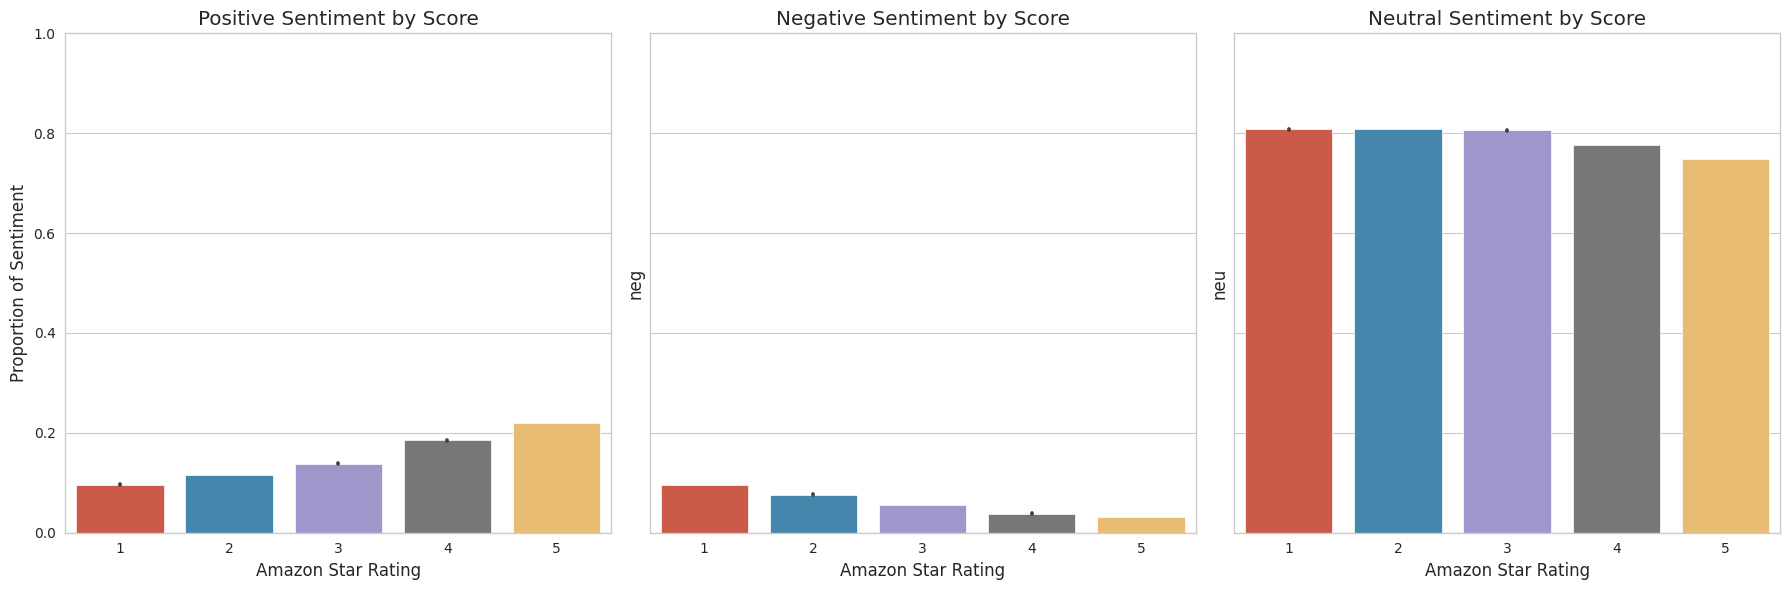

In [13]:

sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot Positive Sentiment
sns.barplot(data=vaders, x="Score", y="pos", ax=axes[0])
axes[0].set_title("Positive Sentiment by Score")
axes[0].set_xlabel("Amazon Star Rating")
axes[0].set_ylabel("Proportion of Sentiment")
axes[0].set_ylim(0, 1)

# Plot Negative Sentiment
sns.barplot(data=vaders, x="Score", y="neg", ax=axes[1])
axes[1].set_title("Negative Sentiment by Score")
axes[1].set_xlabel("Amazon Star Rating")

# Plot Neutral Sentiment
sns.barplot(data=vaders, x="Score", y="neu", ax=axes[2])
axes[2].set_title("Neutral Sentiment by Score")
axes[2].set_xlabel("Amazon Star Rating")


for ax in axes:
    ax.axhline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

**Most are positive beacuse the most score was 5 stars so that's why!**

# Roberta Pretrained Model

**Transformer model accounts for the words but also the context related to other words.**

In [14]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [15]:
import warnings
warnings.filterwarnings("ignore")
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

2025-07-17 14:59:46.936190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752764387.164263      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752764387.232426      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [16]:
import torch
from torch.nn.functional import softmax
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt', truncation=True)
    with torch.no_grad():
        output = model(**encoded_text)
    scores_tensor = output[0][0].detach().cpu()
    scores = softmax(scores_tensor, dim=-1).numpy()
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

res = {}
for i, row in tqdm(df.head(1000).iterrows(), total=1000):
    try:
        text = str(row['Text'])[:500] if pd.notnull(row['Text']) else ""
        myid = row['Id']

        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{k}": v for k, v in vader_result.items()}

        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both

    except Exception as e:
        print(f'Error for id {myid}: {e}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [17]:
results_df=pd.DataFrame(res).T
results_df=results_df.reset_index().rename(columns={'index':'Id'})
results_df=results_df.merge(df,how="left")

In [18]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.069,0.770,0.161,0.8803,0.002680,0.087701,0.909619,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Compare Scores between models

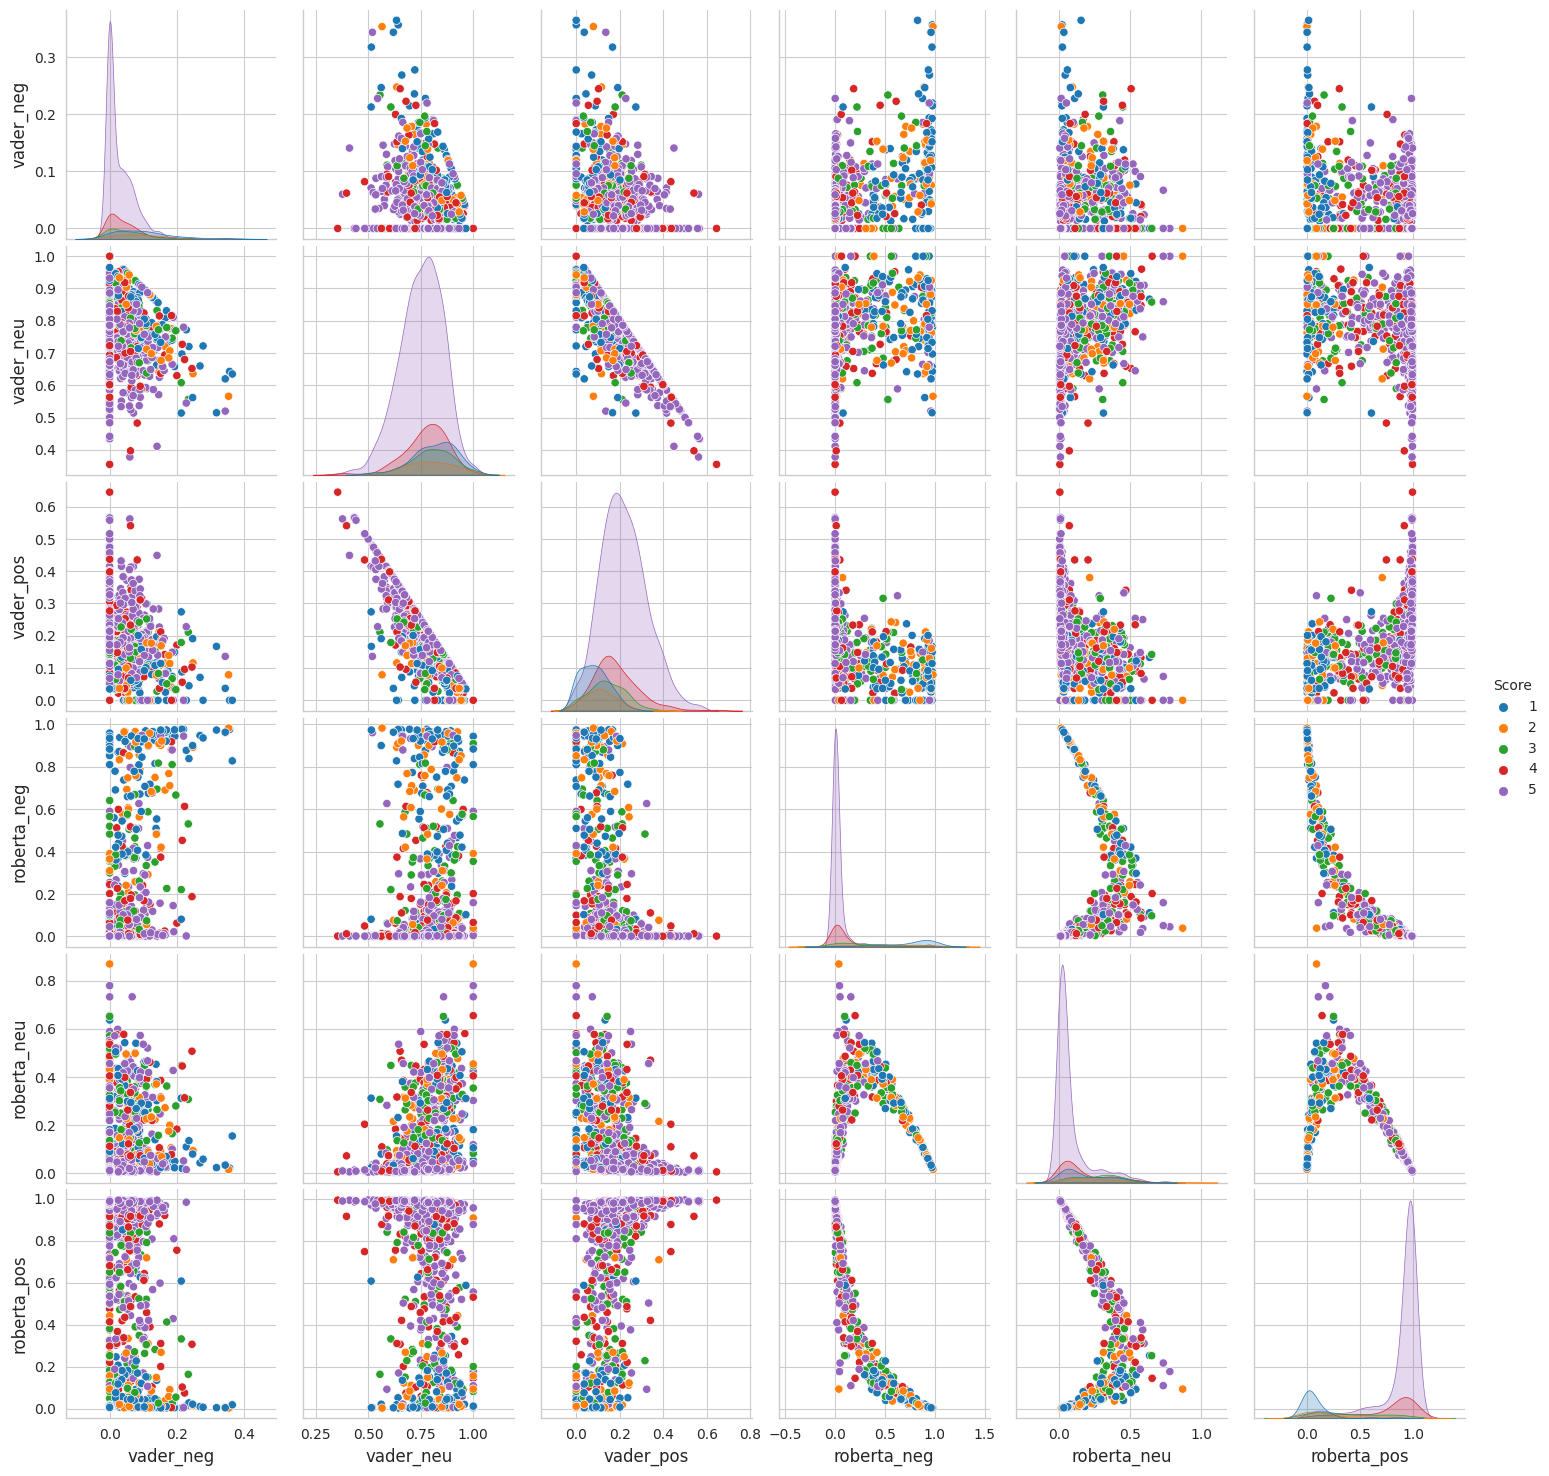

In [19]:
import warnings
warnings.filterwarnings("ignore")
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                   'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score',
             palette='tab10')
plt.show()

# Visualization

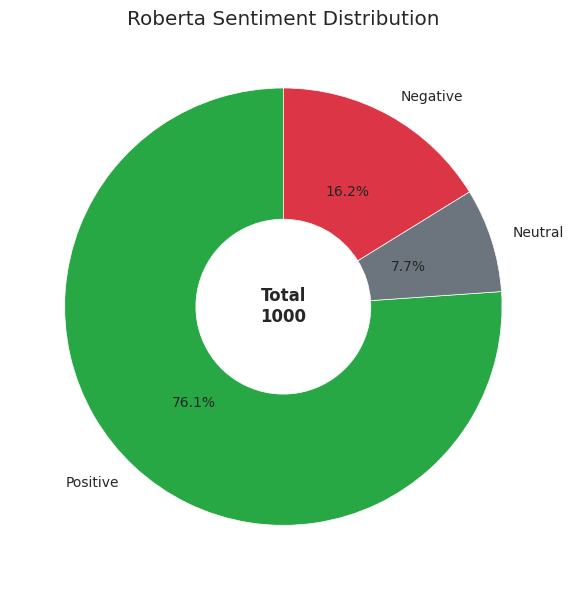

In [20]:
import matplotlib.pyplot as plt

def get_dominant(df, prefix):
    cols = [f"{prefix}_pos", f"{prefix}_neu", f"{prefix}_neg"]
    return df[cols].idxmax(axis=1).str.replace(f"{prefix}_", "")

# Classify dominant Roberta sentiment
results_df["roberta_dominant"] = get_dominant(results_df, "roberta")

# Count sentiment types
roberta_counts = results_df["roberta_dominant"].value_counts().reindex(["pos", "neu", "neg"], fill_value=0)

# Chart setup
labels = ["Positive", "Neutral", "Negative"]
colors = ['#28A745', '#6C757D', '#DC3545']

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(roberta_counts, labels=labels, colors=colors,
       autopct='%1.1f%%', startangle=90,
       wedgeprops={'width': 0.6})
ax.text(0, 0, f"Total\n{roberta_counts.sum()}", ha='center', va='center', fontsize=12, fontweight='bold')
ax.set_title("Roberta Sentiment Distribution")

plt.tight_layout()
plt.show()

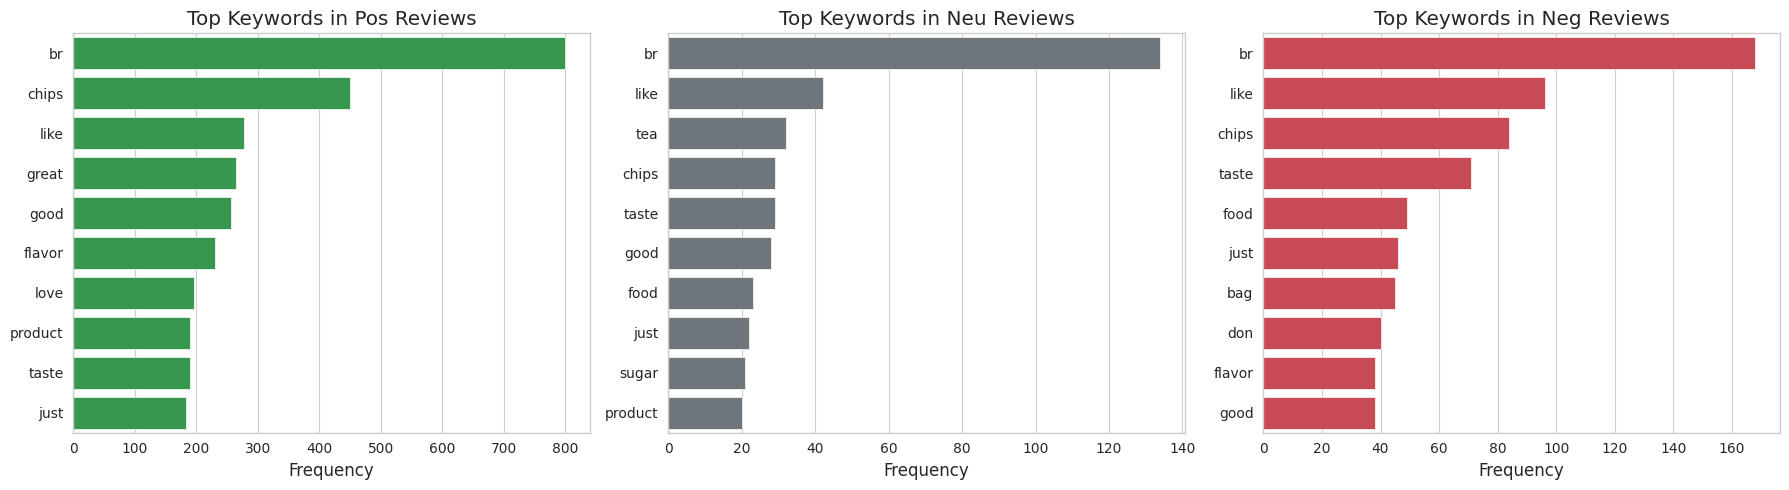

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

def get_dominant(df, prefix):
    cols = [f"{prefix}_pos", f"{prefix}_neu", f"{prefix}_neg"]
    return df[cols].idxmax(axis=1).str.replace(f"{prefix}_", "")

results_df["roberta_dominant"] = get_dominant(results_df, "roberta")
def get_top_keywords(df, label, text_col='Text', n=10):
    subset = df[df["roberta_dominant"] == label]
    vec = CountVectorizer(stop_words='english', max_features=1000)
    bow = vec.fit_transform(subset[text_col])
    word_counts = pd.DataFrame({'word': vec.get_feature_names_out(),
                                'count': bow.sum(axis=0).A1})
    top_words = word_counts.sort_values('count', ascending=False).head(n)
    return top_words


labels = ["pos", "neu", "neg"]
colors = ['#28A745', '#6C757D', '#DC3545']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, label in enumerate(labels):
    data = get_top_keywords(results_df, label)
    sns.barplot(data=data, x='count', y='word', color=colors[i], ax=axes[i])
    axes[i].set_title(f"Top Keywords in {label.capitalize()} Reviews")
    axes[i].set_xlabel("Frequency")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

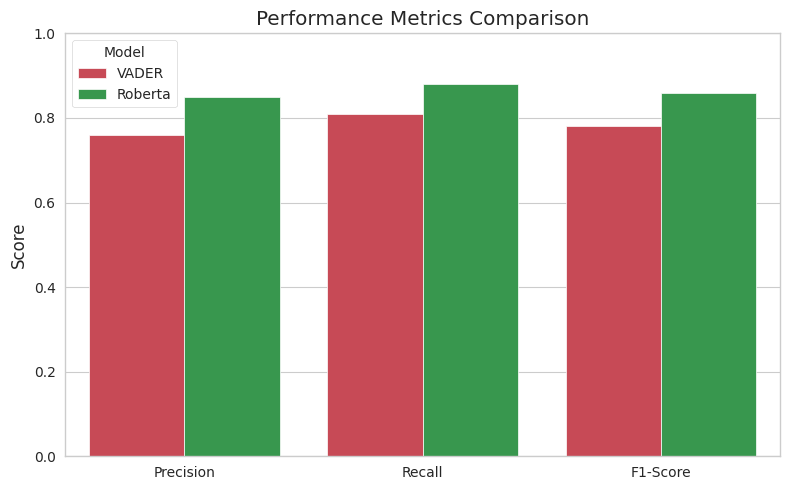

In [22]:

metric_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-Score"],
    "VADER": [0.76, 0.81, 0.78],
    "Roberta": [0.85, 0.88, 0.86]
})

# Melt for seaborn compatibility
metric_melted = metric_df.melt(id_vars="Metric", var_name="Model", value_name="Score")


sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=metric_melted, x="Metric", y="Score", hue="Model", palette=["#DC3545", "#28A745"])

plt.title("Performance Metrics Comparison")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

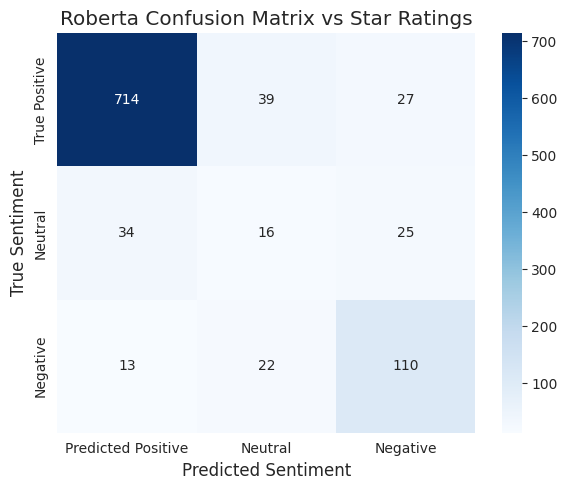

In [23]:
from sklearn.metrics import confusion_matrix
def label_from_score(score):
    if score >= 4:
        return "pos"
    elif score == 3:
        return "neu"
    else:
        return "neg"

# Create true labels from score
results_df["true_label"] = results_df["Score"].apply(label_from_score)


# Create matrix
cm = confusion_matrix(results_df["true_label"], results_df["roberta_dominant"], labels=["pos", "neu", "neg"])

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Positive", "Neutral", "Negative"],
            yticklabels=["True Positive", "Neutral", "Negative"])

plt.title("Roberta Confusion Matrix vs Star Ratings")
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.tight_layout()
plt.show()
